In [1]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from glob import glob
import itertools
import warnings
from importlib import reload

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

# Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.utils.fixes import loguniform
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
# from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, remapping, pop_decoding

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [2]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*-Events.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [3]:
# Get spike counts in each time bin, for all neurons in the study.
pop_spikes = pop_decoding.load_pop_spikes()

print(pop_spikes)

457 neurons
500 ms time bins
36 trials
160 time bins/trial
pop_spikes: (5760, 460)


In [4]:
load_single_file = True

start_time = time()

# Load all time OLS result files.
filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'all_units_time',
                   'ols-time_bin-model_pairs-457units.pkl')
if load_single_file and op.exists(filename):
    ols_pairs = dio.open_pickle(filename)
else:
    ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))
    print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

    warnings.filterwarnings('ignore')
    bad_files = []
    ols_pairs = pd.DataFrame([])
    for filename in ols_pairs_files:
        try:
            ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
        except:
            bad_files.append(filename)
    ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
    warnings.resetwarnings()

    # Restrict dataframe rows to navigation periods.
    keep_cols = ['subj_sess', 'neuron', 'gameState', 'testvar', 'full', 'llf_full', 'lr', 'z_lr', 'emp_pval']
    # ols_pairs = ols_pairs.query("(gameState==['Encoding', 'Retrieval'])")[keep_cols].reset_index(drop=True)
    ols_pairs = ols_pairs[keep_cols].reset_index(drop=True)

    # Organize categorical columns.
    test_vars = ['time', 'place', 'head_direc', 'is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
    test_var_cat = pd.CategoricalDtype(test_vars, ordered=True)
    ols_pairs['testvar'] = ols_pairs['testvar'].astype(test_var_cat)

#     full_models = ['time', 'time_place', 'full']
#     full_model_cat = pd.CategoricalDtype(full_models, ordered=True)
#     ols_pairs['full'] = ols_pairs['full'].astype(full_model_cat)

    # Add new columns.
    roi_map = spike_preproc.roi_mapping(n=3)
    val_map = od([('hem', []),
                  ('roi', []),
                  ('roi_gen', []),
                  ('spike_mat'        , []),
                  ('mean_frs'         , []),
                  ('sem_frs'          , []),
                  ('fr_mean'          , []),
                  ('fr_max'           , []),
                  ('fr_max_ind'       , []),
                  ('sparsity'         , [])])
    for idx, row in ols_pairs.iterrows():
        if 'event_spikes' not in dir():
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        elif event_spikes.subj_sess != row['subj_sess']:
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
        hem = hemroi[0]
        roi = hemroi[1:]
        roi_gen = roi_map.get(roi, np.nan)
        spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
        mean_frs = time_bin_analysis.get_mean_frs(spike_mat) * 2
        sem_frs = time_bin_analysis.get_sem_frs(spike_mat) * 2
        fr_mean = np.mean(mean_frs.values)
        fr_max = np.max(mean_frs.values)
        fr_max_ind = np.argmax(mean_frs.values)
        sparsity = time_bin_analysis.get_sparsity(spike_mat)

        val_map['hem'].append(hem)
        val_map['roi'].append(roi)
        val_map['roi_gen'].append(roi_gen)
        val_map['spike_mat'].append(spike_mat.values.tolist())
        val_map['mean_frs'].append(mean_frs.tolist())
        val_map['sem_frs'].append(sem_frs.tolist())
        val_map['fr_mean'].append(fr_mean)
        val_map['fr_max'].append(fr_max)
        val_map['fr_max_ind'].append(fr_max_ind)
        val_map['sparsity'].append(sparsity)

    ols_pairs.insert(0, 'subj', ols_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
    ols_pairs.insert(2, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
    ols_pairs.insert(4, 'hem', val_map['hem'])
    ols_pairs.insert(5, 'roi', val_map['roi'])
    ols_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
    for col_name in val_map:
        if col_name not in ols_pairs:
            ols_pairs[col_name] = val_map[col_name]
    roi_gen_cat = ['Hippocampus', 'MTL', 'Cortex']
    ols_pairs['roi_gen'] = ols_pairs['roi_gen'].astype(pd.CategoricalDtype(roi_gen_cat, ordered=True))
    ols_pairs.insert(ols_pairs.columns.tolist().index('roi_gen')+1, 'roi_gen2', ols_pairs['roi_gen'].tolist())
    ols_pairs.loc[ols_pairs['roi_gen']=='Hippocampus', 'roi_gen2'] = 'MTL'
    ols_pairs['roi_gen2'] = ols_pairs['roi_gen2'].astype(pd.CategoricalDtype(['MTL', 'Cortex'], ordered=True))
    
    # Test significance.
    alpha = 0.05
    ols_pairs['sig'] = False
    ols_pairs.loc[((ols_pairs['emp_pval']<alpha)), 'sig'] = True
    ols_pairs['sig_holm'] = ols_pairs.groupby(['subj_sess_unit', 'gameState', 'full'])['emp_pval'].transform(lambda x: sm.stats.multipletests(x, alpha, method='holm')[0])

    print('{} bad files'.format(len(bad_files)))

    
def _fr_max_ind(spike_mat, bins=10):
    return np.argmax([v.sum() for v in np.split(np.sum(spike_mat, axis=0), bins)])

icol = ols_pairs.columns.tolist().index('fr_max_ind') + 1
if 'fr_max_ind10' not in ols_pairs:
    ols_pairs.insert(icol, 'fr_max_ind10', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 10)))
if 'fr_max_ind5' not in ols_pairs:
    ols_pairs.insert(icol+2, 'fr_max_ind5', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 5)))

print('ols_pairs:', ols_pairs.shape)

print('Done in {:.1f}s'.format(time() - start_time))

ols_pairs: (5027, 35)
Done in 0.5s


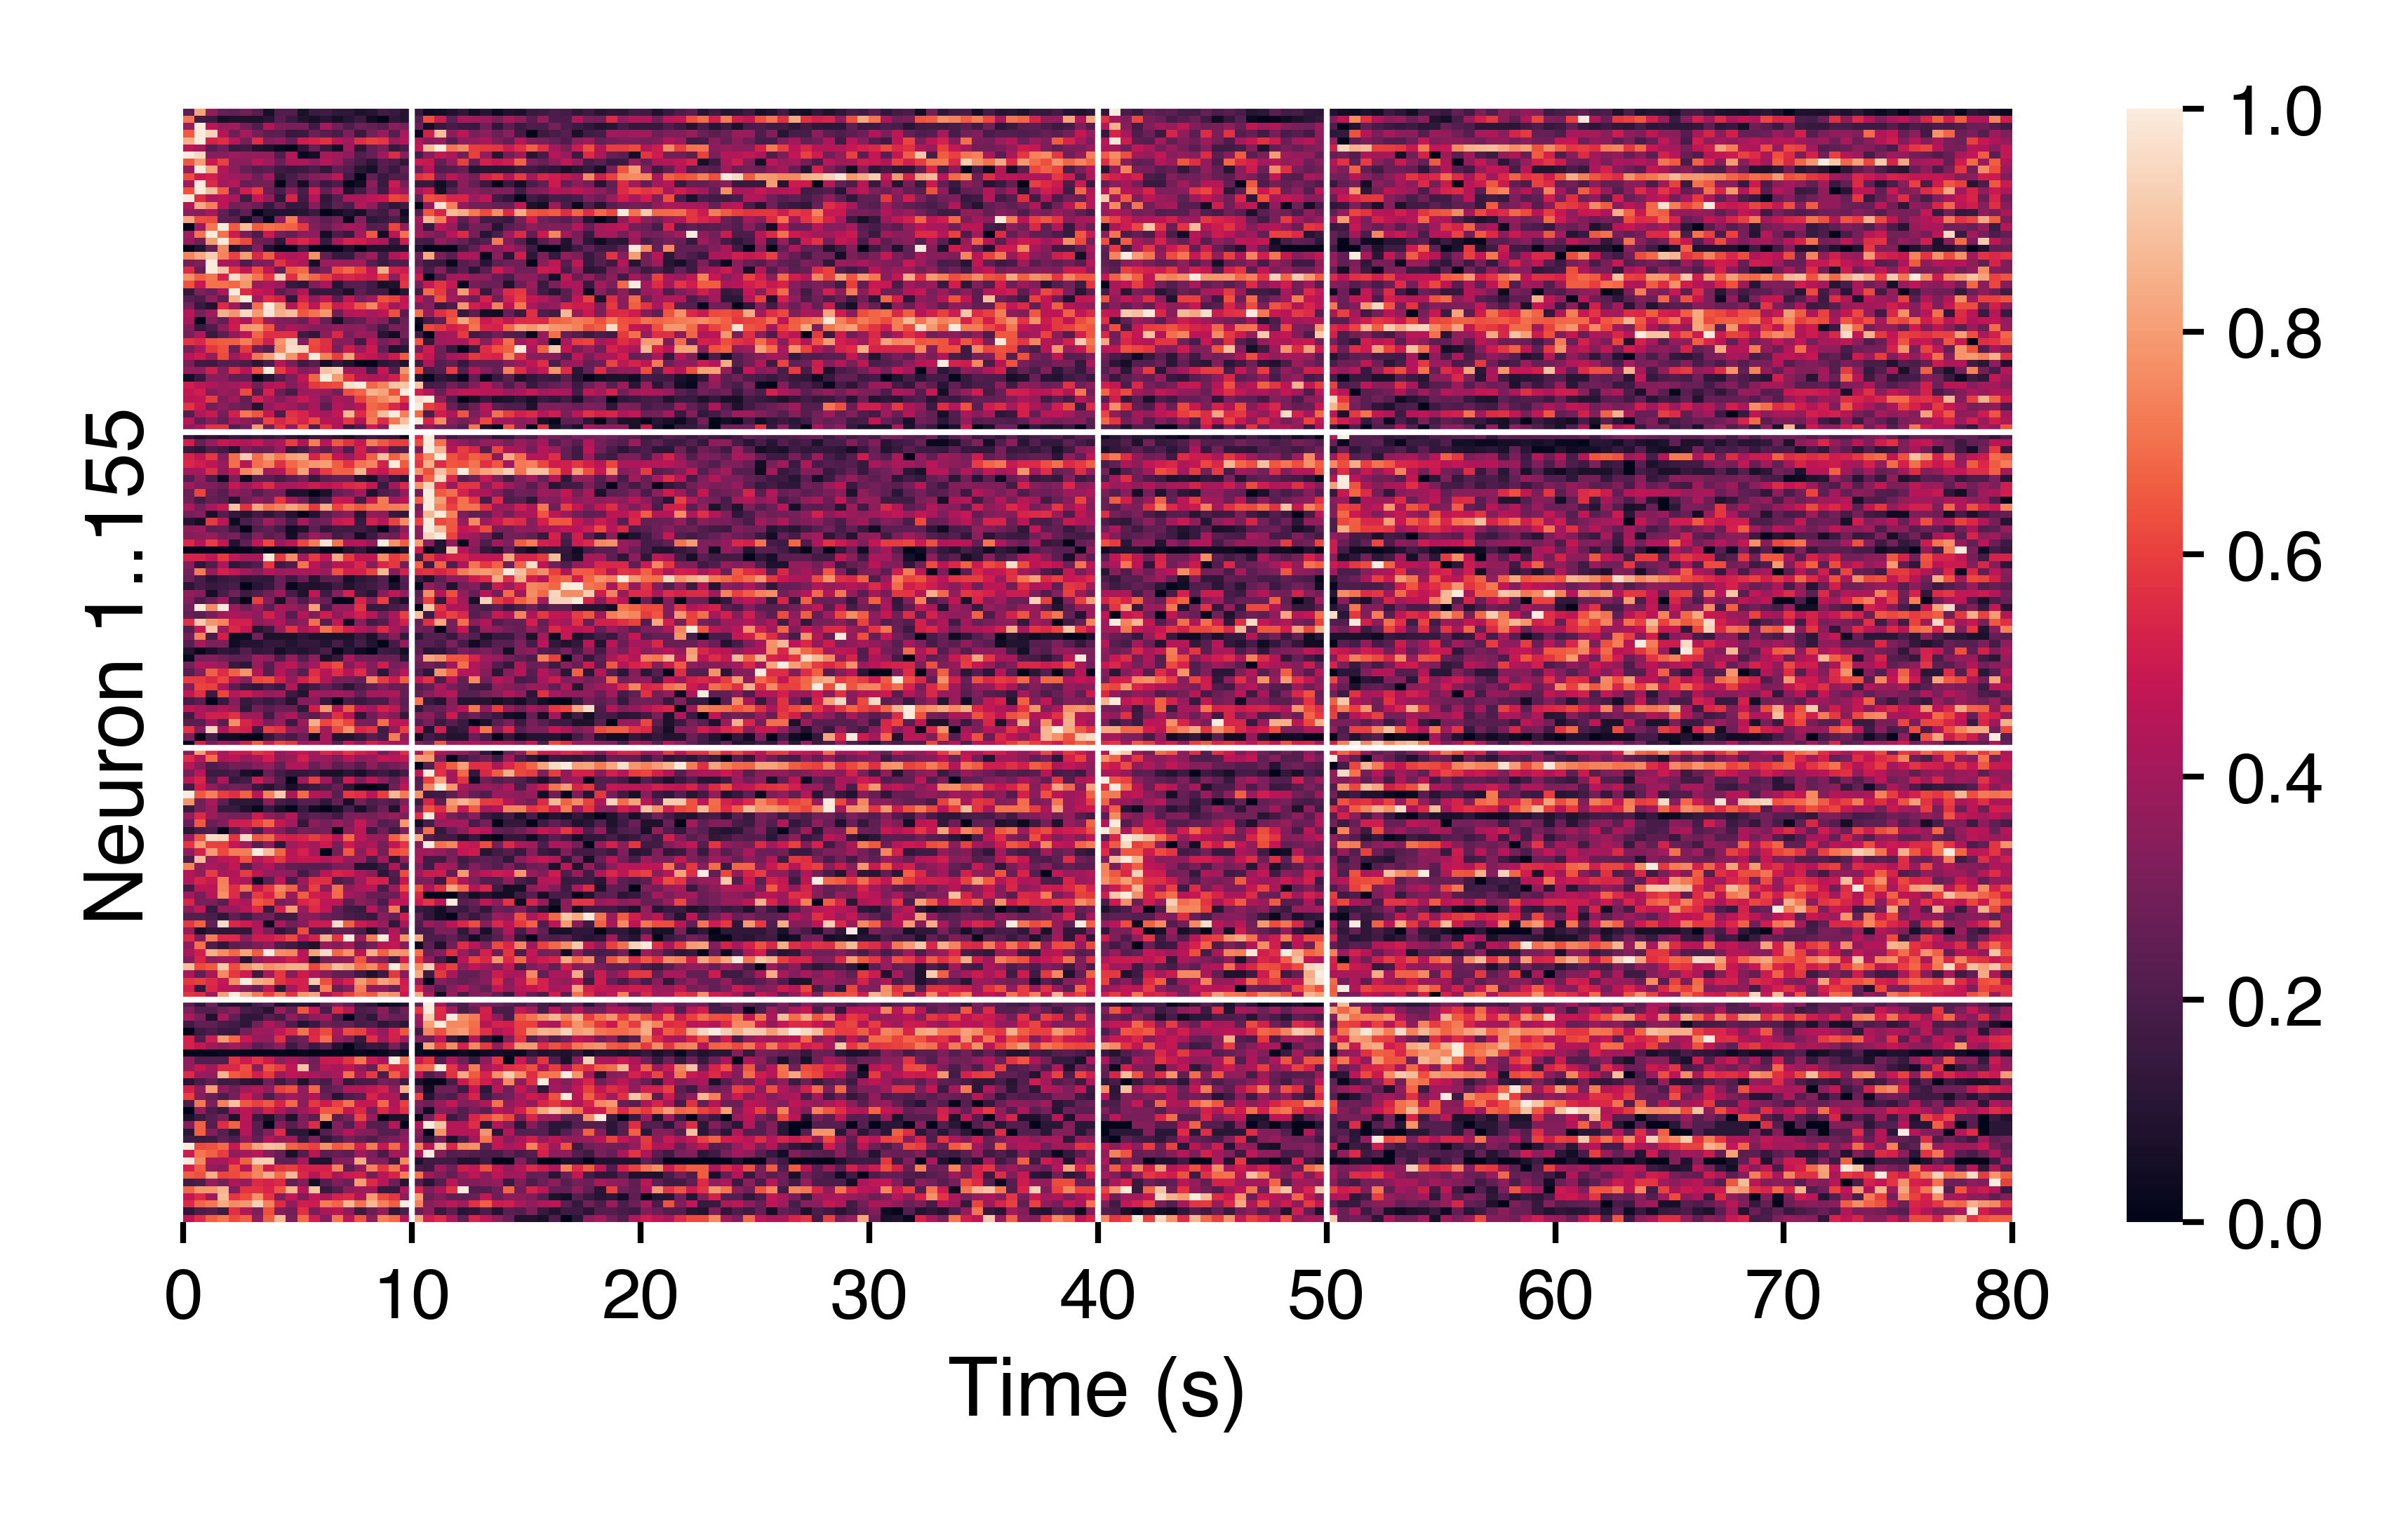

In [7]:
# Plot mean firing rates over time for all time cells, across all 4 trial intervals.
time_step_size = 500
savefig = 0
overwrite = 0
figsize = (colws['nat1w'], colws['nat1w']/2)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
vlines = np.array([0, 10, 40, 50, 80]) * (1000 / time_step_size)
vmin = 0
vmax = 1
add_cbar = True
cbar_ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])
tickpad = 2
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
xlinewidth = 0.5

plt.close()
fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)

# Get data to plot.
all_time_cells = (ols_pairs
                  .query("(testvar=='time') & (sig==True) & (beta_abs_max>0)")
                  .sort_values('z_lr', ascending=0)
                  .drop_duplicates('subj_sess_unit')
                  .sort_values(['gameState', 'beta_abs_argmax', 'z_lr'], ascending=[1, 1, 0])
                  .reset_index(drop=True)['subj_sess_unit'].values)
pop_spikes = pop_decoding.load_pop_spikes()
mean_frs = minmax_scale(pop_spikes
                        .combine_time_bins(time_step_size=time_step_size)
                        .groupby(['iGameStateTime'], observed=True)
                        [all_time_cells].mean().T.values, axis=1) # neuron x time
mat = mean_frs
n_neurons, n_time_steps = mat.shape
xticks = np.arange(0, n_time_steps+1, 10/(80/n_time_steps), dtype=int)
xticklabels = [int(x) for x in (xticks * (80/n_time_steps))]
hlines = [0] + np.cumsum(ols_pairs
                         .query("(testvar=='time') & (sig==True) & (beta_abs_max>0)")
                         .sort_values('z_lr', ascending=0)
                         .drop_duplicates('subj_sess_unit')
                         .groupby('gameState').size()).tolist()

# Make heatmap.
iax = 0
ax[iax] = sns.heatmap(mat, vmin=vmin, vmax=vmax, cmap='rocket', cbar=add_cbar, ax=ax[iax])
ax[iax].hlines(hlines[1:-1], 0, n_time_steps, colors='w', linewidths=xlinewidth)
ax[iax].vlines(np.array(vlines)[1:-1], 0, n_neurons, colors='w', linewidths=xlinewidth)
ax[iax].tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
_xticks = xticks
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels, rotation=0)
ax[iax].set_yticks([])
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylabel('Neuron 1..{}'.format(n_neurons), fontsize=font['label'], labelpad=labelpad)
if add_cbar:
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_remapping', 
                       'mean_firing_rates_over_time-{}timebins-{}_time_cells-{}units.pdf'.format(n_time_steps, len(all_time_cells), pop_spikes.neurons.size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')

fig.show()

In [140]:
# Calculate representational similarity across trial interval boundaries.
time_step_size = 1000
savefile = False

start_time = time()

# Get a list of all significant time cells in any of
# the four trial intervals.
filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'all_units_time',
                   'ols-time_bin-model_pairs-457units.pkl')
ols_pairs = dio.open_pickle(filename)
all_time_cells = ols_pairs.query("(testvar=='time') & (sig==True) & (beta_abs_max>0)")['subj_sess_unit'].unique().tolist()

# Get all non-matching trial pairs.
pop_spikes = pop_decoding.load_pop_spikes()
trials = pop_spikes.pop_spikes['trial'].unique().tolist()
n_trials = len(trials)
trial_pairs = remapping.pairwise_combs(n_trials)

# Aggregate spikes within time steps.
_pop_spikes = pop_spikes.combine_time_bins(time_step_size=time_step_size)

# Keep only time cells.
neurons = all_time_cells
print('{} neurons'.format(len(neurons)))
keep_cols = ['trial', 'gameState', 'iGameState', 'iGameStateTime', 'time_step'] + neurons
_pop_spikes = _pop_spikes[keep_cols]

# Z-score each neuron's firing across time steps.
_pop_spikes[neurons] = stats.zscore(_pop_spikes[neurons], axis=0)

# Reconfigure _pop_spikes into a trial x iGameStateTime dataframe
# whose values are list of firing rates across neurons, all in the same order.
_pop_spikes['neurons'] = _pop_spikes[neurons].values.tolist()
_pop_spikes = _pop_spikes[['trial', 'iGameStateTime', 'neurons']]
_pop_spikes = _pop_spikes.pivot(index='trial', columns='iGameStateTime', values='neurons') # trial x iGameStateTime

# Calculate Pearson correlations between each time pair, within each trial pair.
qry = "(trial=={}) & (iGameStateTime=={})"
ctrls = ['wrong_time1', 'wrong_time2', 'wrong_gs1', 'wrong_gs2']
trial_pair_corrs = []
for iTrial1, iTrial2 in trial_pairs:
    trial1 = trials[iTrial1]
    trial2 = trials[iTrial2]
    frs_1 = np.array(_pop_spikes.loc[trial1].values.tolist()) # time_step x neuron
    frs_2 = np.array(_pop_spikes.loc[trial2].values.tolist()) # time_step x neuron
    trial_pair_corrs.append(cosine_similarity(stats.zscore(frs_1, axis=1),
                                              stats.zscore(frs_2, axis=1))
                            .tolist()) # time_step x time_step; pearson corrs
trial_pair_corrs = np.array(trial_pair_corrs) # trial_pair x time_step x time_step

if savefile:
    filename = op.join(proj_dir, 'analysis', 'remapping',
                       'trial_pair_corrs-{}ms_bins-{}_time_cells-{}_units.pkl'
                       .format(time_step_size, len(all_time_cells), ols_pairs['subj_sess_unit'].unique().size))
    dio.save_pickle(pwise_corrs, filename)
    
print('Done in {:.1f}s'.format(time() - start_time))

155 neurons
Done in 5.8s


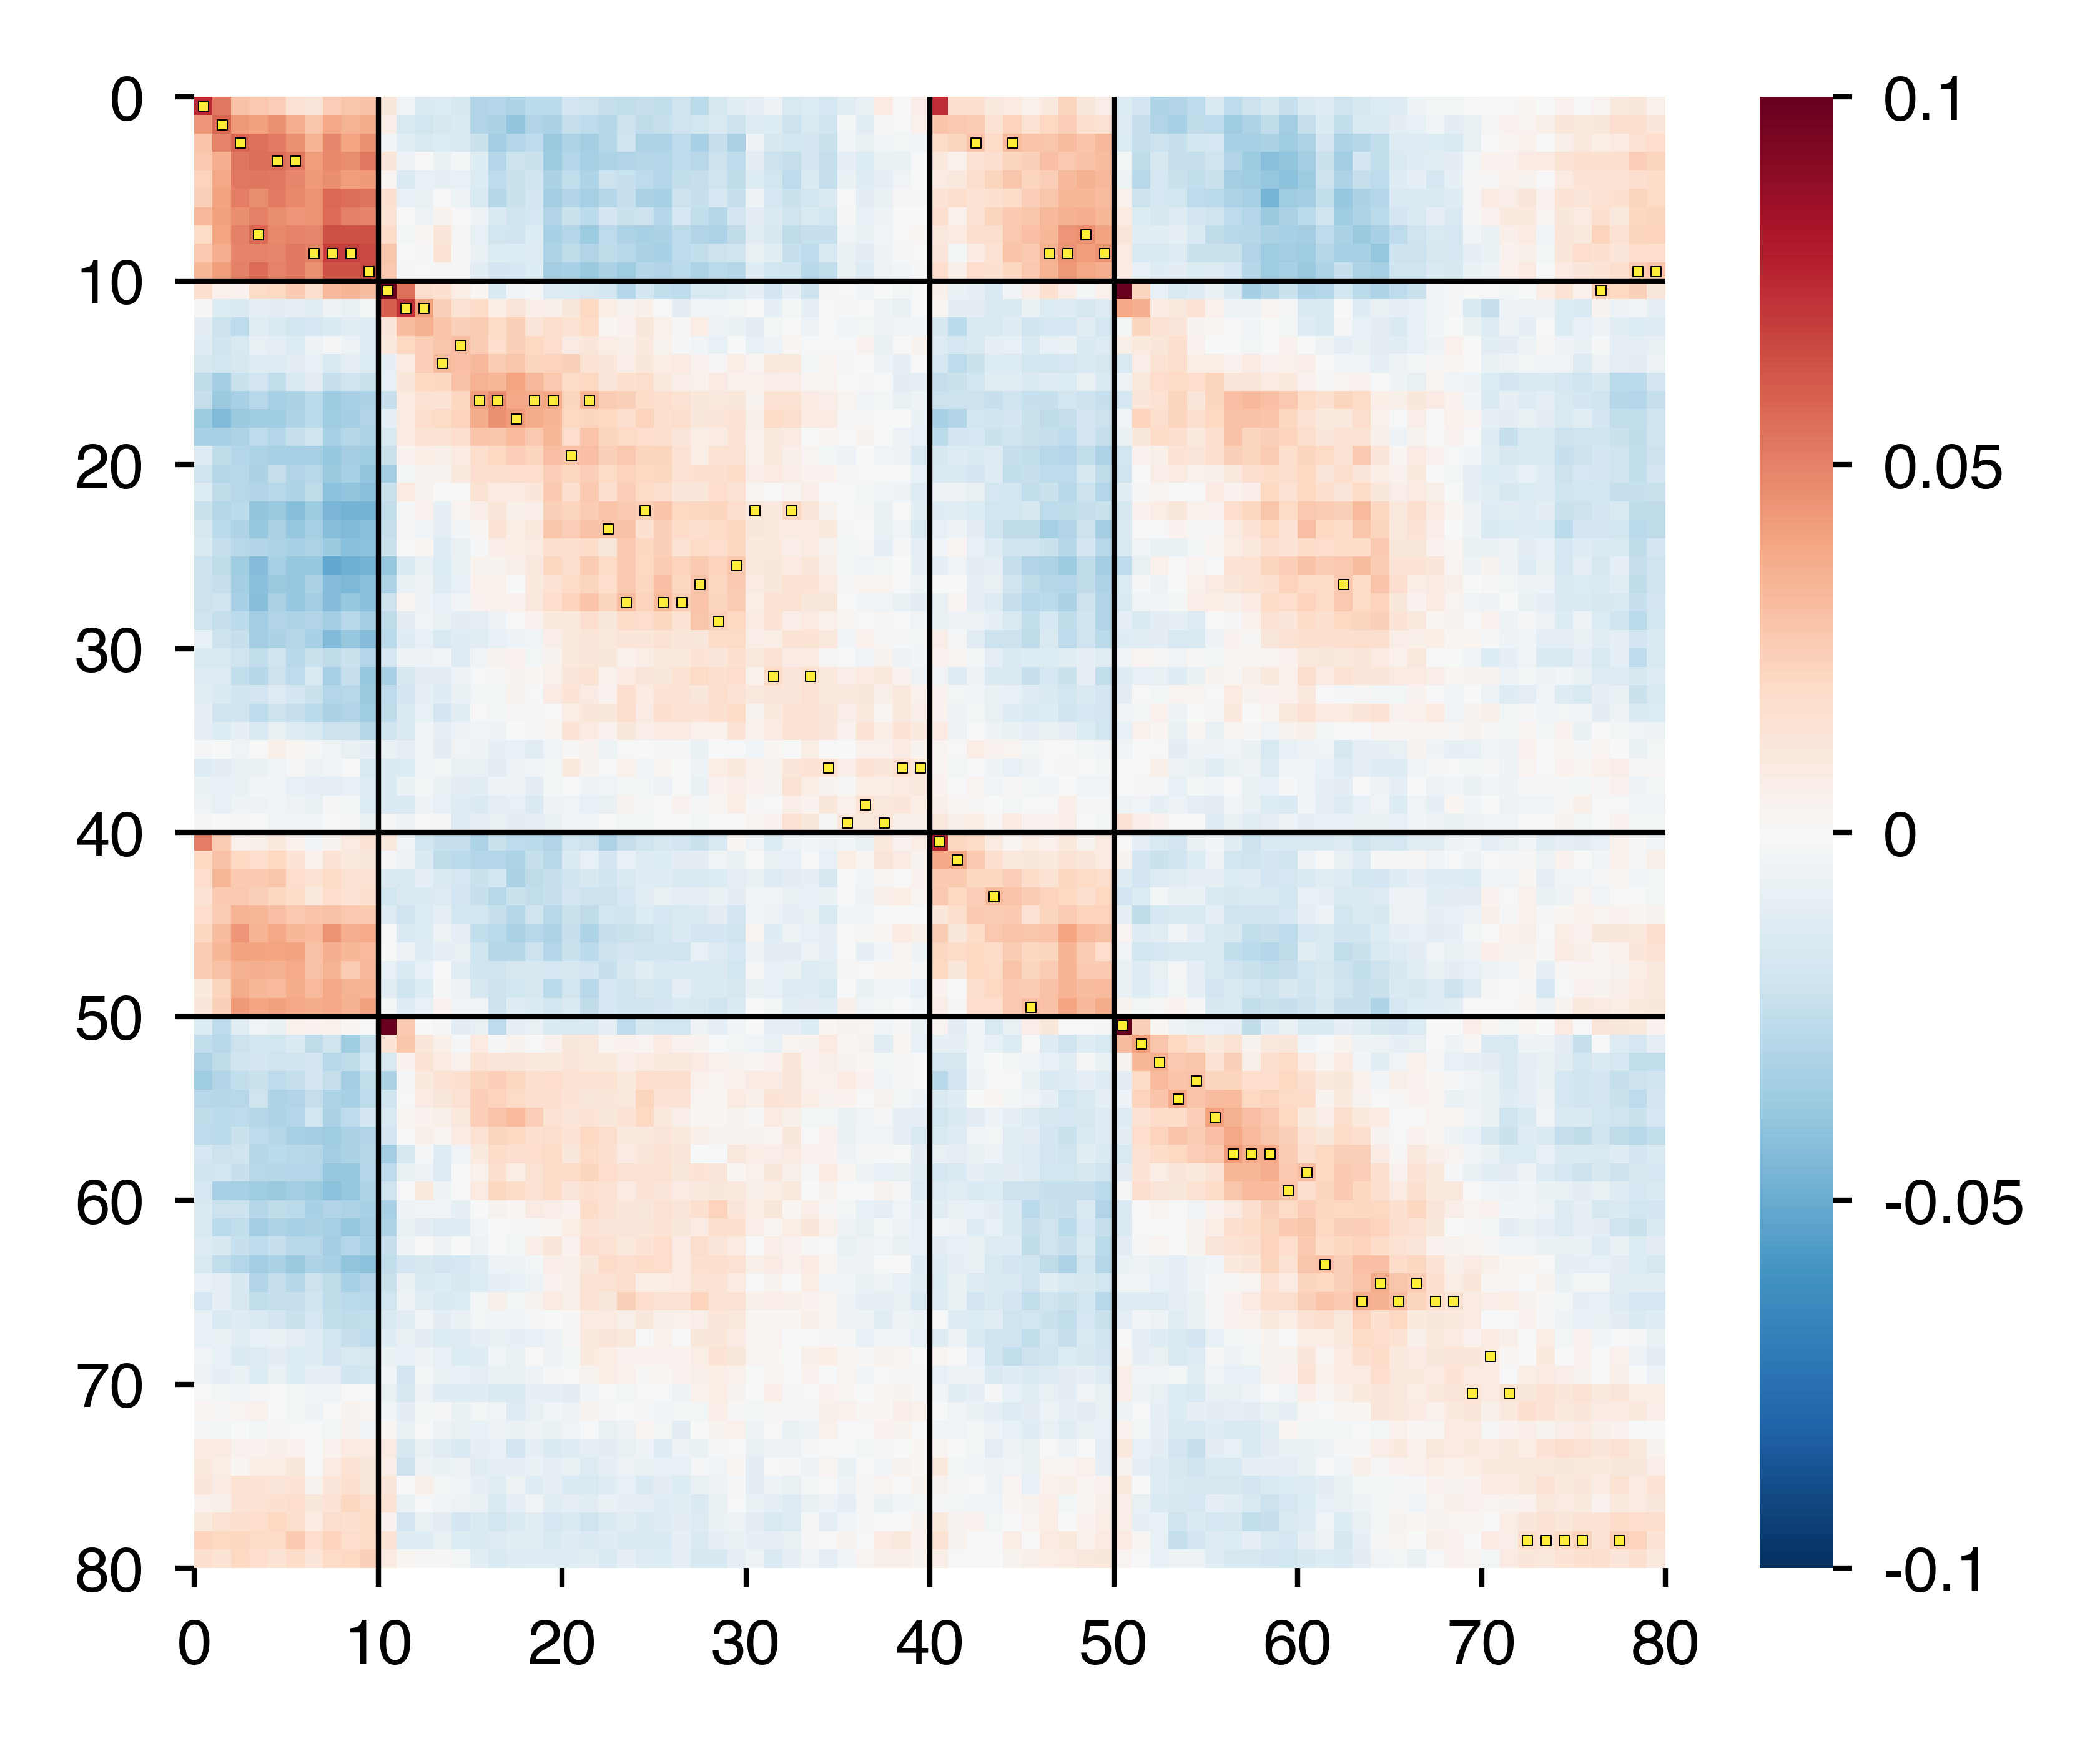

In [143]:
savefig = 0
overwrite = 1
figsize = (3.25, 2.6)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
vlines = np.array([0, 10, 40, 50, 80]) * (1000/time_step_size)
square = True
xticks = np.arange(vlines[0], vlines[-1]+1, step=int(10 * (1000/time_step_size)), dtype=int)
xticklabels = np.arange(0, 81, step=10, dtype=int)
add_cbar = 1
cbar_ticks = [-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15]
ticklength = 3
tickpad = 3
xlinewidth = 0.5
spine_lw = 0.5
spine_len = 1.8
scatter_size = 1
scatter_lw = 0.12

# Z-score each neuron's firing across time steps, then calculate the Pearson correlation
# between population firing rates in each pair of time steps.
cmat = np.mean(trial_pair_corrs, axis=0)
vmax = np.max(np.abs((cmat.min(), cmat.max())))
vmin = -vmax
vmax = 0.1
vmin = -vmax

# Plot the results.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, ax=ax[iax], square=square, cmap='RdBu_r')
ax[iax].hlines(np.array(vlines)[1:-1], 0, vlines[-1], colors='k', linewidths=xlinewidth)
ax[iax].vlines(np.array(vlines)[1:-1], 0, vlines[-1], colors='k', linewidths=xlinewidth)
ax[iax].scatter(np.arange(cmat.shape[0]) + 0.5, np.argmax(cmat, axis=0) + 0.5, marker='s',
                s=scatter_size, color='#ffec3b', lw=scatter_lw, edgecolor='k')
ax[iax].tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
ax[iax].set_xticks(xticks)
ax[iax].set_xticklabels(xticklabels, rotation=0)
ax[iax].set_yticks(ax[iax].get_xticks())
ax[iax].set_yticklabels(ax[iax].get_xticklabels(), rotation=0)
if add_cbar:
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)
else:
    ax[iax].collections[0].colorbar.remove()
    
if savefig:
    n_timebins = cmat.shape[0]
    filename = op.join(proj_dir, 'figs', 'plot_remapping',
                       'pearson_corrs_between_{}ms_time_steps-diff_trial_pairs-redBlue-{}time_cells-{}units.pdf'.format(time_step_size, len(all_time_cells), pop_spikes.neurons.size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')

fig.show()

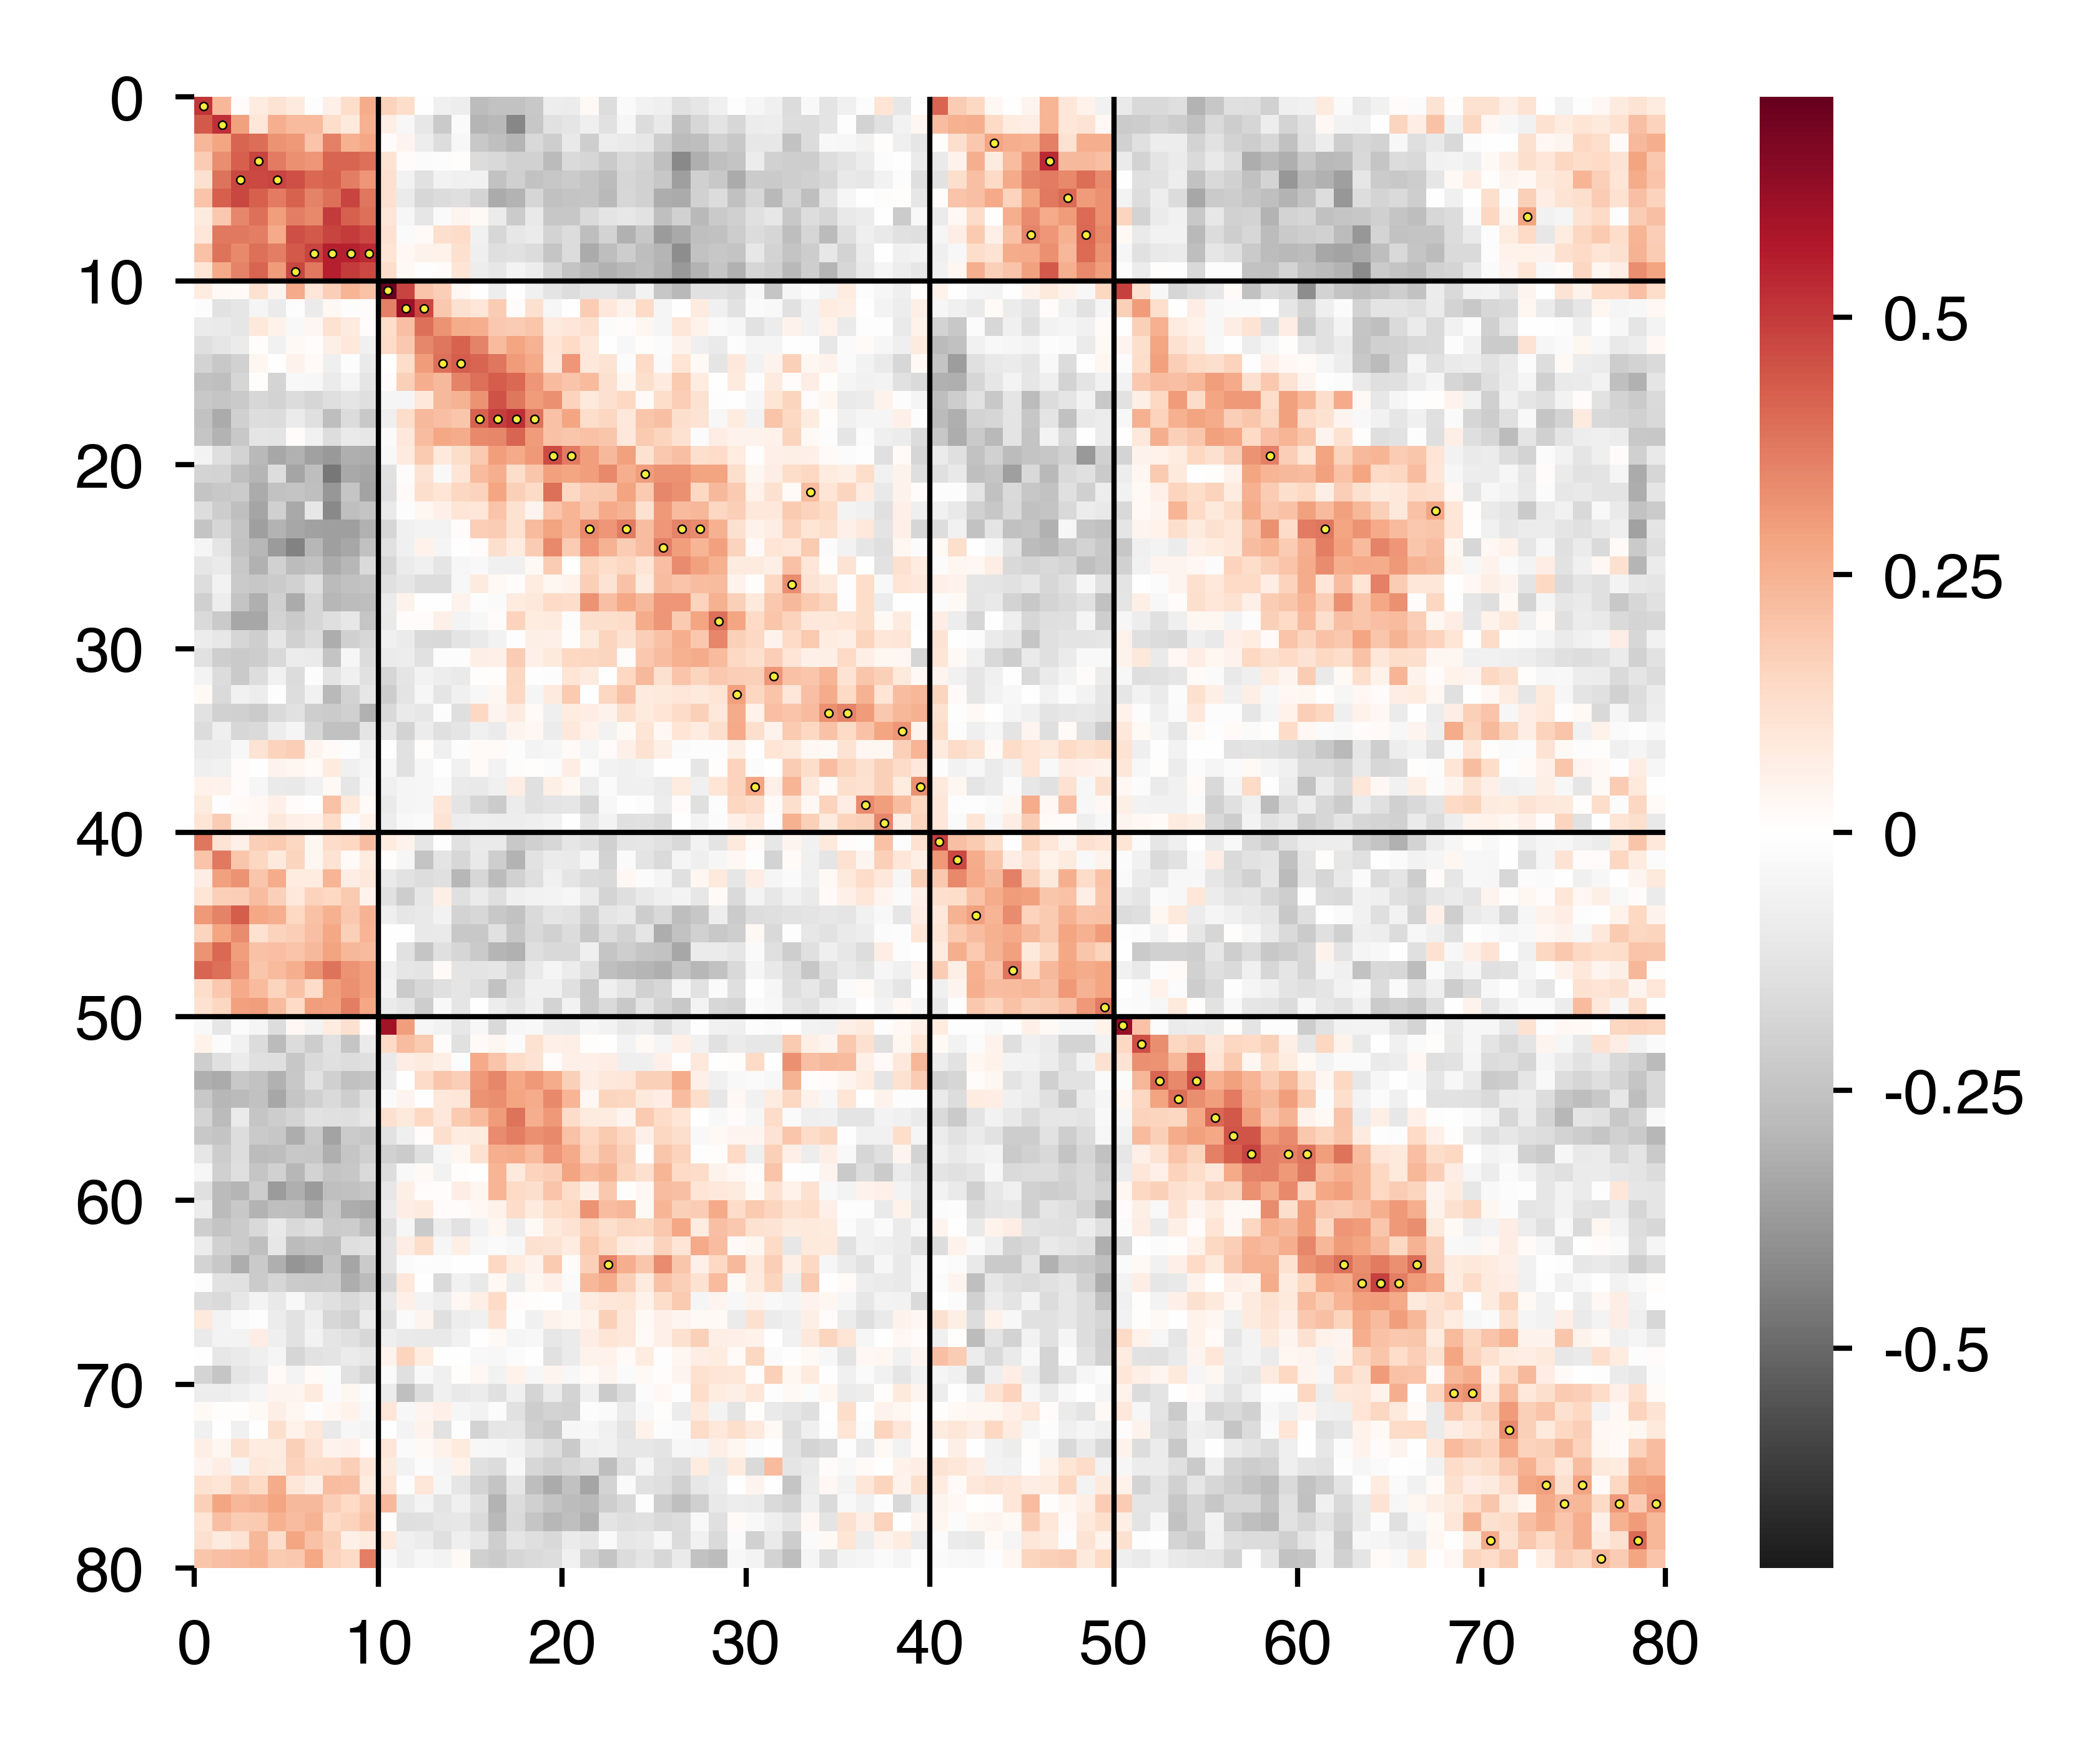

In [91]:
savefig = 0
overwrite = 0
time_step_size = 1000
place_adj = False
figsize = (3.25, 2.6)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
vlines = np.array([0, 10, 40, 50, 80]) * (1000/time_step_size)
square = True
xticks = np.arange(vlines[0], vlines[-1]+1, step=int(10 * (1000/time_step_size)), dtype=int)
xticklabels = np.arange(0, 81, step=10, dtype=int)
add_cbar = 1
cbar_ticks = [-0.5, -0.25, 0, 0.25, 0.5]
ticklength = 3
tickpad = 3
xlinewidth = 0.5
spine_lw = 0.5
spine_len = 1.8
scatter_size = 0.6
scatter_lw = 0.15

# Z-score each neuron's firing across time steps, then calculate the Pearson correlation
# between population firing rates in each pair of time steps.
all_time_cells = ols_pairs.query("(testvar=='time') & (sig==True) & (beta_abs_max>0)")['subj_sess_unit'].unique().tolist()
pop_spikes = pop_decoding.load_pop_spikes(place_adj=place_adj)
if 'is_odd' not in pop_spikes.pop_spikes.columns:
    pop_spikes.pop_spikes.insert(1, 'is_odd', (pop_spikes.pop_spikes['trial']%2==1).astype(int))
pop_spikes_odd = pop_spikes.combine_time_bins(pop_spikes.pop_spikes.query("(is_odd==1)"), time_step_size)
pop_spikes_even = pop_spikes.combine_time_bins(pop_spikes.pop_spikes.query("(is_odd!=1)"), time_step_size)

zfrs_train = stats.zscore(pop_spikes_odd.groupby('iGameStateTime')[all_time_cells].sum(), axis=0) # time_step x neuron
zfrs_test = stats.zscore(pop_spikes_even.groupby('iGameStateTime')[all_time_cells].sum(), axis=0) # time_step x neuron
# cmat = cosine_similarity(zfrs_train, zfrs_test) # time_step x time_step; cosine sims
cmat = cosine_similarity(stats.zscore(zfrs_train, axis=1),
                         stats.zscore(zfrs_test, axis=1)) # time_step x time_step; pearson corrs
vmax = np.max(np.abs((cmat.min(), cmat.max())))
vmin = -vmax

# Plot the results.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, ax=ax[iax], square=square, cmap='RdGy_r')
ax[iax].hlines(np.array(vlines)[1:-1], 0, vlines[-1], colors='k', linewidths=xlinewidth)
ax[iax].vlines(np.array(vlines)[1:-1], 0, vlines[-1], colors='k', linewidths=xlinewidth)
ax[iax].scatter(np.arange(cmat.shape[0]) + 0.5, np.argmax(cmat, axis=0) + 0.5,
                s=scatter_size, color='#ffec3b', lw=scatter_lw, edgecolor='k')
ax[iax].tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
ax[iax].set_xticks(xticks)
ax[iax].set_xticklabels(xticklabels, rotation=0)
ax[iax].set_yticks(ax[iax].get_xticks())
ax[iax].set_yticklabels(ax[iax].get_xticklabels(), rotation=0)
if add_cbar:
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)
else:
    ax[iax].collections[0].colorbar.remove()
    
if savefig:
    n_timebins = cmat.shape[0]
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'pearson_corrs_between_{}ms_time_step_pairs-odd_even_split-redBlue-{}time_cells-{}units.pdf'.format(time_step_size, len(all_time_cells), pop_spikes.neurons.size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')

fig.show()